In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
from pyro import clear_param_store
import pyro.contrib.gp as gp
from pyro.nn import PyroSample
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive,HMC
import torch
import kennard_stone as ks
import arviz as az
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral
from bokeh.models import Slope, Div
from bokeh.io import curdoc
from bokeh.layouts import column,gridplot
from print_versions import print_versions
from sklearn.metrics import r2_score
from seaborn import clustermap
from bokeh.models import Band, ColumnDataSource


In [10]:

PM25=pd.read_excel(r"pm25.xlsx")
PM25=PM25.loc[PM25.pm_final.isna()==0,:]
X_full, y_full=PM25.loc[:,["sv_final","flow"]],PM25.loc[:,["pm_final","sv_final"]]
X_train, X_test, y_train, y_test = ks.train_test_split(X_full, y_full, test_size = 0.2)

2025-02-05 10:48:45,988 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-02-05 10:48:46,035 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



In [12]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)

In [18]:
X,y=torch.tensor(X_train.flow.values).float(),torch.tensor(y_train.pm_final.values).float()

In [26]:
clear_param_store()
rbf = gp.kernels.RBF(input_dim=1)

rbf.variance = PyroSample(dist.HalfNormal(torch.tensor(10.)))

rbf.lengthscale = PyroSample(dist.LogNormal(torch.tensor(0.), torch.tensor(0.4)))

periodic = gp.kernels.Periodic(input_dim=1)
periodic.period=PyroSample(dist.HalfNormal(torch.tensor(10.)))
periodic.lengthscale=PyroSample(dist.HalfNormal(torch.tensor(10.)))
X=torch.tensor(PM25.flow.values).float()
y=torch.tensor(PM25.pm_final.values).float()

k = gp.kernels.Product(rbf, periodic)
gpr = gp.models.GPRegression(X,y, rbf)
gpr.noise = PyroSample(dist.HalfNormal(torch.tensor(20.)))
#k1 = gp.kernels.Product(kern0=rbf, kern1=periodic)



nuts_kernel = NUTS(gpr.model,target_accept_prob=0.8)

mcmc = MCMC(nuts_kernel, num_samples=1000,warmup_steps=2000,num_chains=1)

mcmc.run()

Sample: 100%|███████████████████████████████████████| 3000/3000 [15:31,  3.22it/s, step size=8.08e-01, acc. prob=0.908]


In [ ]:
mcmc_combined.diagnostics(),mcmc_combined.summary(prob=0.9)

In [11]:
posterior_samples = mcmc_combined.get_samples()
posterior_predictive = Predictive(gpr_combined, posterior_samples)(X
)
prior = Predictive(gpr_combined, num_samples=500)(X)

pyro_data = az.from_pyro(mcmc_combined,
    prior=prior,
    posterior_predictive=posterior_predictive,

)
pyro_data

C:\Users\michael.forsmann\anaconda3\Lib\site-packages\arviz\data\io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> observed_data

In [ ]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data, backend="bokeh")
ax = az.plot_density(
    [pyro_data],
    data_labels=["pyro_data"],
    shade=0.1,
    backend="bokeh",
)

In [48]:
logliklighood(gpr_combined,X)

tensor(8.3146e+10, grad_fn=<NegBackward0>)

In [46]:
logliklighood(gpr,X)

NameError: name 'gpr' is not defined

In [44]:
def logliklighood(gpr,X):
    N=torch.tensor(X.shape[0])
    return -torch.sum(-N/2*torch.log(2*N)-N/2*torch.log(gpr(X)[1]**2)-(y-gpr(X)[0])**2/(2*gpr(X)[1]**2))

In [137]:
torch.log(gpr(X)[1]**2)+(y-gpr(X)[0])**2/gpr(X)[1]**2

tensor([  3.1010, 817.5109, 426.6153,  ..., 207.3916, 528.6503,  79.3487],
       grad_fn=<AddBackward0>)

In [125]:
from pyro.contrib.gp.likelihoods.likelihood import Likelihood

In [127]:
1/2 *torch.sum(torch.log(gpr(X)[1]**2)+(y-gpr(X)[0])**2/gpr(X)[1]**2)

tensor(1.0025e+08, grad_fn=<MulBackward0>)

In [110]:
Likelihood(gpr(X)[0])

TypeError: Likelihood.__init__() takes 1 positional argument but 2 were given

In [63]:
# tell gpr that we want to get samples from guides
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))



variance = 6.540896892547607
lengthscale = 0.32743197679519653
noise = 8.206345558166504


(3.3, 4.6)

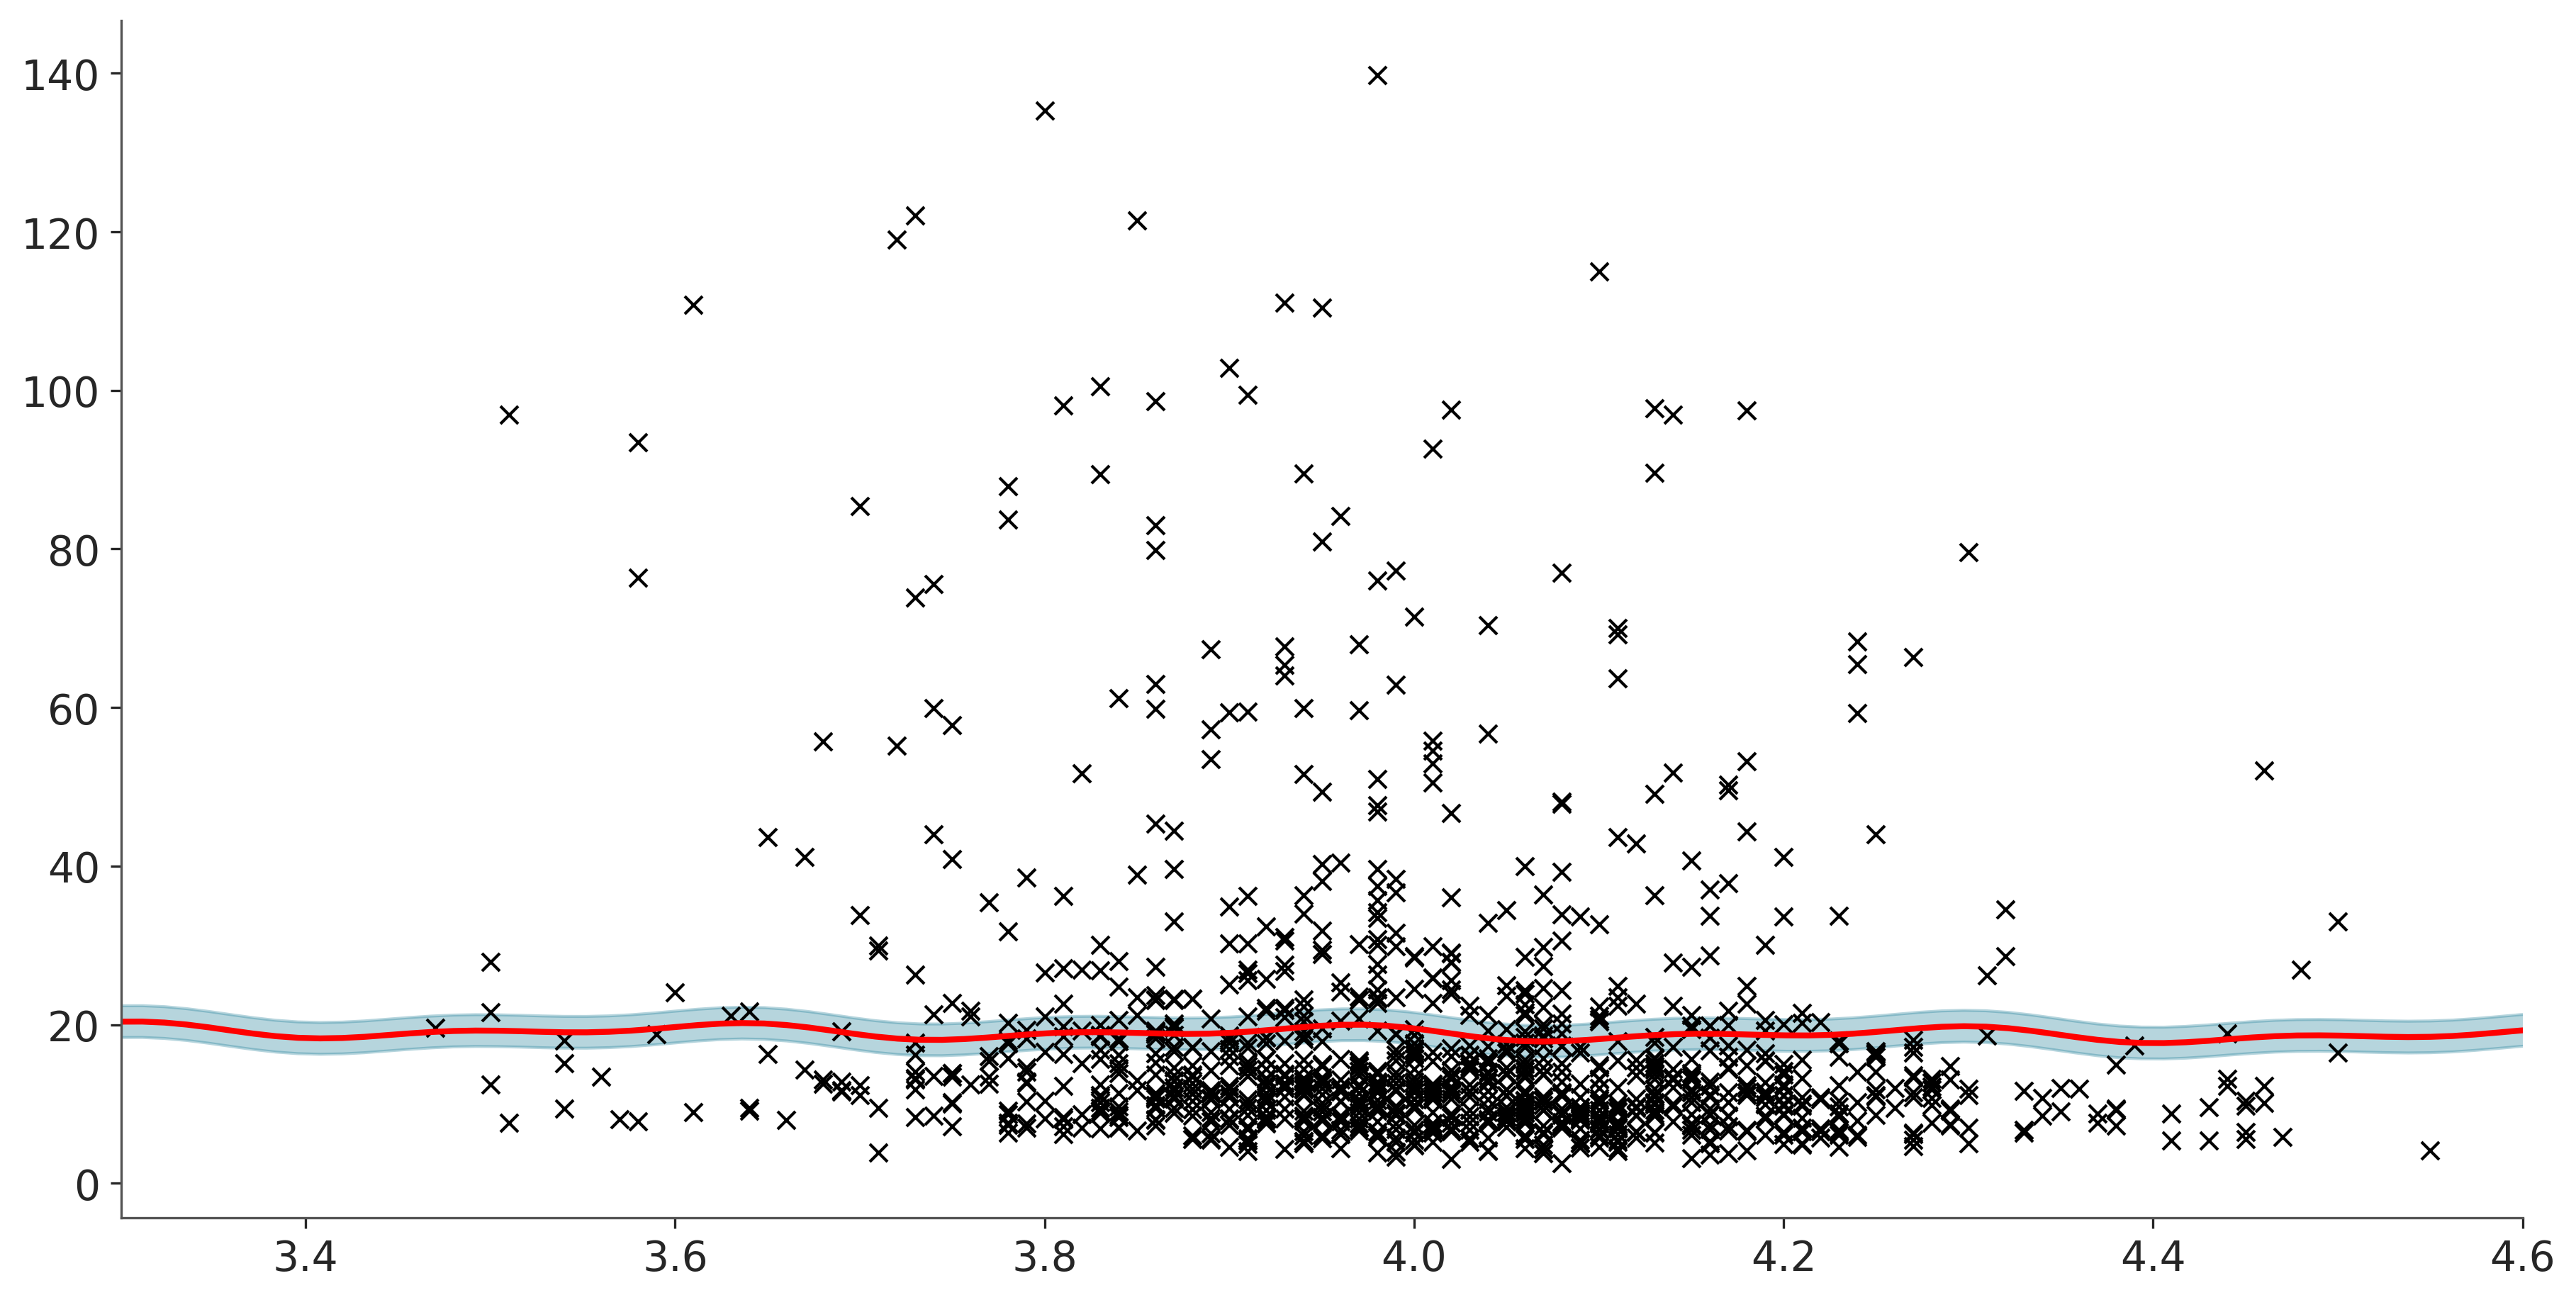

In [21]:
plot(model=gpr_combined, plot_observed_data=True, plot_predictions=True)
plt.xlim(3.3,4.6)

In [26]:
PM25=PM25.sorted(flow)

AttributeError: 'DataFrame' object has no attribute 'sorted'

In [78]:
df

,Unnamed: 0,fnr,bnr,vejnvn,husn,sadto,flow,postnr,pm_final,sv_final,adrnum,maalnr,y_mean,y_std,lower,upper
0,0,9,1,Høgevej,8,2000-07-05,4.07,4683,3.747515,0.162272,1,1,NaN,NaN,NaN,NaN
1,1,66,1,Høgevej,8,2000-12-12,3.75,4683,13.850762,3.059650,1,2,NaN,NaN,NaN,NaN
2,2,340,1,Høgevej,8,2001-07-14,4.22,4683,6.937794,0.342990,1,3,NaN,NaN,NaN,NaN
3,3,7,3,Peter Sabroesgade,25,2000-07-05,3.78,2450,83.668164,0.961510,1,1,NaN,NaN,NaN,NaN
4,4,71,3,Peter Sabroesgade,25,2000-12-12,3.74,2450,59.950123,1.789893,1,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,1117,1229,450,Bavnehøj Park,23,2003-05-27,3.96,3500,13.039686,0.562392,1,3,19.277872,17.284803,1.993069,36.562675
1118,1118,677,451,Vangedevej,226A,2002-04-05,3.88,2860,23.291217,1.544408,1,1,19.323791,17.277078,2.046713,36.600869
1119,1119,649,452,CT Barfoeds Vej,3,2002-03-10,3.92,2000,18.355211,1.032809,1,1,19.338470,17.274369,2.064102,36.612839
1120,1120,926,452,CT Barfoeds Vej,3,2002-10-19,4.05,2000,19.422368,2.665289,1,2,19.377909,17.260959,2.116950,36.638868


In [ ]:
import numpy as np
import pandas as pd

from bokeh.models import Band, ColumnDataSource
from bokeh.plotting import figure, show

PM25=PM25.sort_values("flow")
df2 = PM25.pm_final.rolling(window=100).agg({"y_mean": "mean", "y_std": "std"})

df = pd.concat([PM25, df2], axis=1)
df["lower"] = df.y_mean - df.y_std
df["upper"] = df.y_mean + df.y_std

df=df
p = figure(tools="", toolbar_location=None, x_range=(3, 6))
p.title.text = "Rolling Standard Deviation"
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5

p.scatter(x="flow", y="pm_final", color="blue", marker="dot", size=10, alpha=0.4, source=df)

p.line(x="flow",y="y_mean", line_dash=(10, 7), line_width=2, source=df)
df1=ColumnDataSource(df)
band = Band(base="flow", lower="lower", upper="upper", source=df1,fill_alpha=0.3, fill_color="yellow", line_color="black")
p.add_layout(band)

show(p)

In [13]:
pyro.clear_param_store()
rbf = gp.kernels.RationalQuadratic(input_dim=1)

rbf.variance = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.01), torch.tensor(5)))

rbf.lengthscale = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.01), torch.tensor(1)))
rbf.scale_mixture = pyro.nn.PyroSample(dist.LogNormal(torch.tensor(0.01), torch.tensor(1)))


X=torch.tensor(PM25.flow.values).float()
y=torch.tensor(PM25.pm_final.values).float()
gpr = gp.models.GPRegression(X,y, rbf)
nuts_kernel = NUTS(gpr.model)


mcmc = MCMC(nuts_kernel, num_samples=10,warmup_steps=10)

mcmc.run(X,y)

Sample: 100%|███████████████████████████████████████████| 20/20 [17:25, 52.30s/it, step size=3.10e-06, acc. prob=0.003]


In [90]:
# tell gpr that we want to get samples from guides
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("scale_mixture = {}".format(gpr.noise))

print("noise = {}".format(gpr.noise))



variance = 285.62554931640625
lengthscale = 0.7575359344482422
scale_mixture = 1.0
noise = 1.0


(3.3, 4.6)

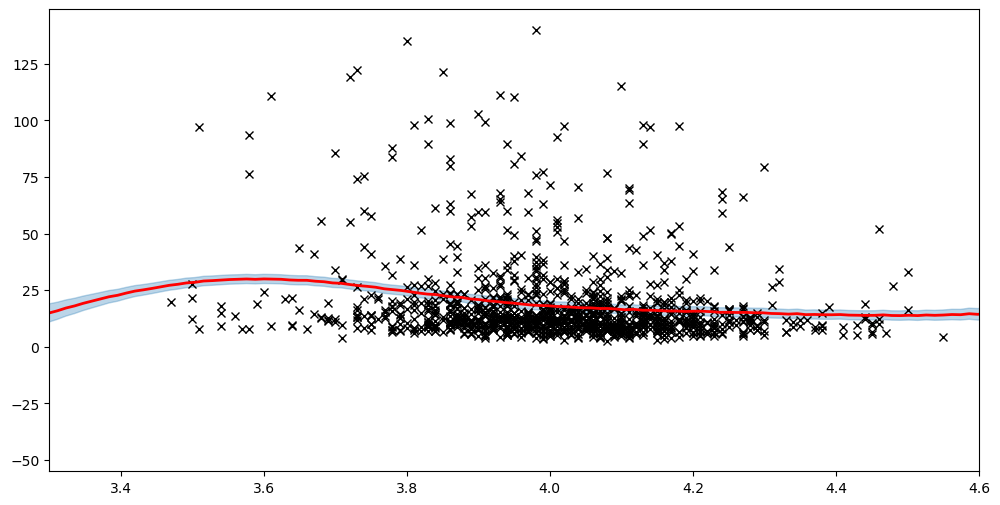

In [18]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)
plt.xlim(3.3,4.6)

In [20]:
sample=mcmc.get_samples()
conditioned_model=poutine.condition(gpr,X)
model_trace=pyro.poutine.trace(conditioned_model).get_trace(X,Y)
obs_node=model_trace.nodes["y_obs"]
loglikehood=obs_node['fn'].log_prob(obs_node['value'])

NameError: name 'poutine' is not defined

NameError: name 'losses' is not defined

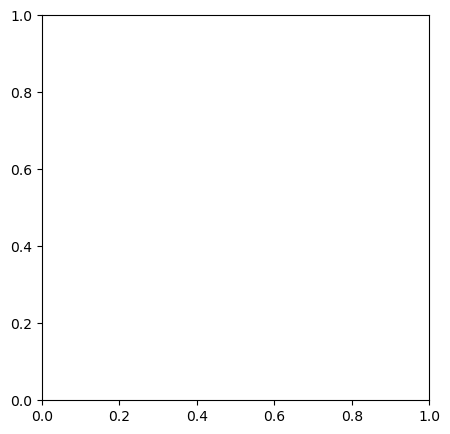

In [14]:

fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.plot(losses)
ax.set_xlabel("iteration")
ax.set_ylabel("-loglikelighood")

AttributeError: 'DataFrame' object has no attribute 'pm25'

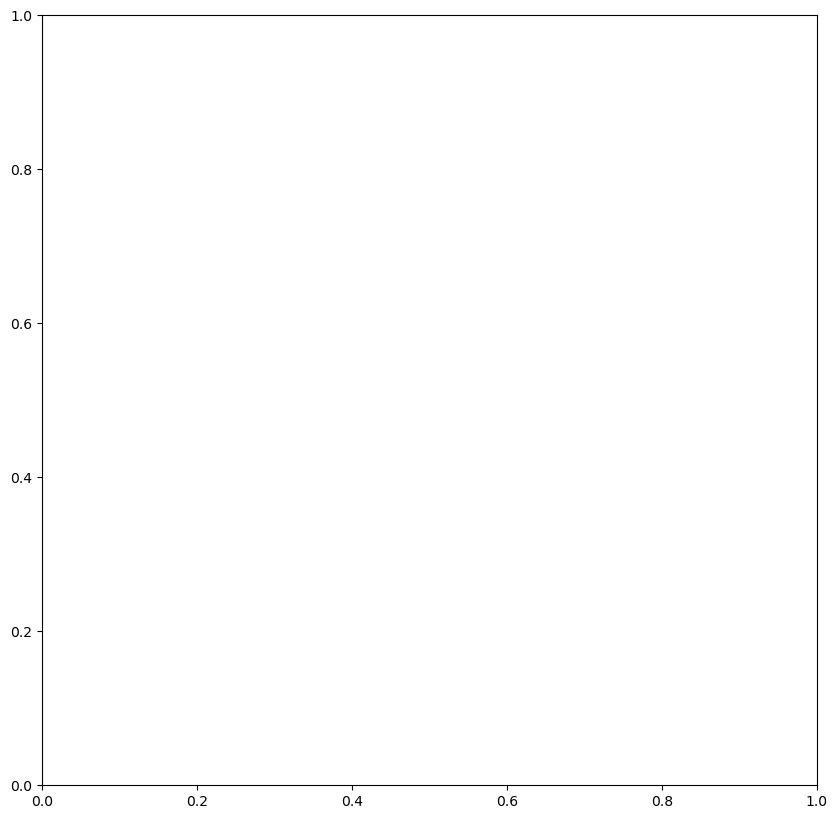

In [60]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
mean_prediction, std_prediction = gpr(X)
mean_prediction=mean_prediction.detach().numpy()
std_prediction=std_prediction.detach().numpy()

ax.scatter(PM25.flow.values, PM25.pm25.values, label="Observations")
ax.plot(X, mean_prediction,"r.", label="Mean prediction")
ax.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.legend()
ax.set_xlabel("$Week$")
ax.set_ylabel("$Concentration$")

In [63]:
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

NameError: name 'sns' is not defined

In [65]:
p=np.polyfit(PM25.flow,PM25.pm25,1)
p_log=np.polyfit(PM25.flow,np.log(PM25.pm25),1)

AttributeError: 'DataFrame' object has no attribute 'pm25'

In [67]:
plt.plot((4*p[0]+p[1])/(PM25.flow*p[0]+p[1]),(gpr(torch.tensor(4*np.ones(len(X))).float())[0]/gpr(X)[0]).detach().numpy(),'.')

NameError: name 'p' is not defined

In [69]:
PM25_corrected=torch.tensor(PM25.pm25) *gpr(torch.tensor(4*np.ones(len(X))).float())[0]/gpr(X)[0]
PM25_log_corrected=PM25.pm25 *(4*p[0]+p[1])/(PM25.flow*p[0]+p[1])

AttributeError: 'DataFrame' object has no attribute 'pm25'

In [71]:
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

NameError: name 'make_interp_spline' is not defined

In [73]:
import seaborn as sns 
from scipy.interpolate import make_interp_spline

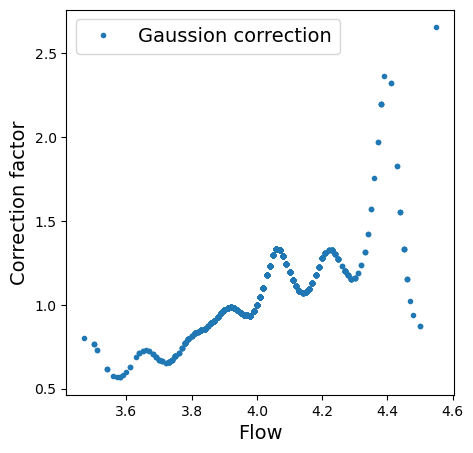

In [76]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
#ax.plot(PM25.flow,(4*p[0]+p[1])/(PM25.flow*p[0]+p[1]),'.',label="Linear correction")
#ax.plot(PM25.flow,(4*p_log[0]+p_log[1])/(PM25.flow*p_log[0]+p_log[1]),'.',label="Log linear correction")
ax.plot(PM25.flow,(gpr(torch.tensor(4*np.ones(len(X))).float())[0]/gpr(X)[0]).detach().numpy(),'.',label="Gaussion correction")
ax.legend(fontsize=14)
ax.set_xlabel("Flow",fontsize=14)
ax.set_ylabel("Correction factor",fontsize=14)
fig.savefig("Correction_flow_models.png")

In [12]:
PM25_corrected

NameError: name 'PM25_corrected' is not defined

C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='pm25', ylabel='Density'>

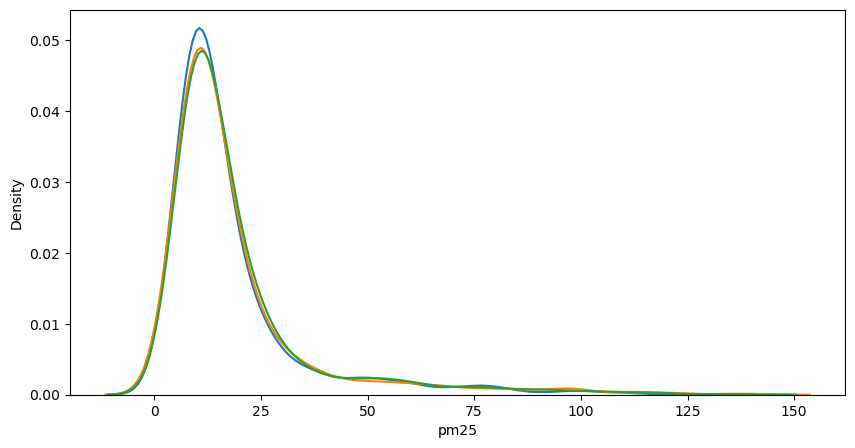

In [86]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.kdeplot(PM25_corrected.detach().numpy(),ax=ax)
sns.kdeplot(PM25.pm25,ax=ax)
sns.kdeplot(PM25_log_corrected,ax=ax)
